<a href="https://colab.research.google.com/github/blufzzz/Dynamic-Texture-3D-CNN/blob/by_fist_3_frames/DynTex_3D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is demo for dynamic texture synthesis via auto-regresion of the frame sequence

In [0]:
# import urllib

# from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
# !pip install --no-cache-dir -I pillow

In [0]:
from skimage import io
import cv2
import os
import sys
import shutil
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.core.display import clear_output
from IPython.core.debugger import set_trace
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from google.colab import files


In [2]:

from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd ./gdrive/My\ Drive/Colab Notebooks/two-stream-dyntex-synth

/content/gdrive/My Drive/Colab Notebooks/two-stream-dyntex-synth


# Define model

In [0]:
class CNN3D(nn.Module):
  
  def __init__(self):
    
    super(CNN3D, self).__init__()
    
    self.d_conv1 = nn.Conv3d(3,64, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_1 = nn.BatchNorm3d(64)
    self.d_pool1 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
    self.d_conv2 = nn.Conv3d(64, 128, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_2 = nn.BatchNorm3d(128)
    self.d_pool2 = nn.MaxPool3d((1,2,2), stride = (1,2,2))

    self.d_conv3 = nn.Conv3d(128, 256, (1,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_3 = nn.BatchNorm3d(256)
    self.d_pool3 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
    
    self.d_conv4 = nn.Conv3d(256, 512, (1,3,3), stride=1, padding=(0,1,1), bias=True)
    self.d_bn_4 = nn.BatchNorm3d(512)
    self.d_pool4 = nn.MaxPool3d((1,2,2), stride = (1,2,2))
        
    
    self.u_unconv1 = nn.ConvTranspose2d(512, 256, (2,2), stride = 2, bias=True)
    self.u_conv1 = nn.Conv2d(256, 256, (3,3), stride = 1, padding=(1,1), bias=True)
    
    self.u_unconv2 = nn.ConvTranspose2d(256, 128, (2,2), stride = 2, bias=True)
    self.u_conv2= nn.Conv2d(128, 128, (3,3), stride = 1, padding=(1,1), bias=True)
    
    self.u_unconv3 = nn.ConvTranspose2d(128, 64, (2,2), stride = 2, bias=True)
    self.u_conv3 = nn.Conv2d(64, 64, (3,3), stride = 1, padding=(1,1), bias=True)

    self.u_unconv4 = nn.ConvTranspose2d(64,3, (1,1), stride = 1, bias=True)
    self.u_conv4 = nn.Conv2d(3, 3, (1,1), stride = 1, bias=True)

    self.relu = nn.LeakyReLU()
        
  def forward(self, x):

    x = self.d_conv1(x)
#     self.res1 = x
#     x = self.d_bn_1(x)
    x = self.d_pool1(x)
    x = self.relu(x)
    
    x = self.d_conv2(x)
#     self.res2 = x
#     x = self.d_bn_2(x)
    x = self.d_pool2(x)
    x = self.relu(x)
    
    x = self.d_conv3(x)
#     self.res3 = x
#     x = self.d_bn_3(x)
    x = self.d_pool3(x)
    x = self.relu(x)
    
    x = self.d_conv4(x)
#     self.res4 = x
#     x = self.d_bn_4(x)
    x = self.relu(x)
    
    x = x.reshape(x.shape[0],
                  x.shape[1], x.shape[-1], x.shape[-1])
    
    x = self.u_unconv1(x)
    x = self.u_conv1(x)
    x = self.relu(x)
    
    x = self.u_unconv2(x)
    x = self.u_conv2(x)
    x = self.relu(x)
    
    x = self.u_unconv3(x)
    x = self.u_conv3(x)
    x = self.relu(x)
    
    x = self.u_unconv4(x)
    x = self.u_conv4(x)
    x = self.relu(x)    
    
    return x
  

In [0]:
# X = torch.randn((4, 3, 3, 256, 256))

# model = CNN3D()
# model.forward(X).shape

аугментация, больше обучающая выборка, попробовать обучаться на всем, генерация 3D из гармоник через инстанс норм, идея с optical flow и refine сеткой

In [0]:
def get_seq(fold, seq_len, i):
  
  names = sorted(os.listdir(fold))

  imgs = []
  
  y = io.imread(os.path.join(fold, names[i+seq_len])).transpose(2,0,1)

  for name in names[i:i+seq_len]:

    imgs += [io.imread(os.path.join(fold, name)).transpose(2,0,1)]
    
  imgs = np.array([imgs]).transpose(0,2,1,3,4)
  
  return torch.squeeze(torch.Tensor(imgs)), torch.Tensor(y)
  
    
def deprocess(img_tensor):

    img = img_tensor[0].detach().cpu().numpy().transpose(1,2,0)

    img= np.clip(img, 0, 255)
    img = img.astype('uint8')

    return  img  

In [0]:
# X,y = get_seq('./data/dynamic_textures/water_1/', 6 ,0)

# X.shape, y.shape

# model.forward(X.view(1,*X.shape).cuda()).shape

In [0]:
class DynTexDataset(Dataset):
  
    def __init__(self, root_dir, texture_names, seq_len, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.texture_names = texture_names
        self.texture_seqlen_dict = {}
        self.seq_len = seq_len

        for name in texture_names:

            texture_fold = os.path.join(root_dir, name)
            n_framesets = len(os.listdir(texture_fold)) - (seq_len + 1)
            self.texture_seqlen_dict[texture_fold] = n_framesets

    def __getitem__(self, idx):

        new_idx = idx

        for texture_fold in self.texture_seqlen_dict.keys():

          if new_idx < self.texture_seqlen_dict[texture_fold]:
              break
          else:
              new_idx -= self.texture_seqlen_dict[texture_fold]
                      
        return get_seq(texture_fold, self.seq_len, new_idx)

    def __len__(self):

        s = 0
        for fold in self.texture_seqlen_dict.keys():
            s+=self.texture_seqlen_dict[fold]
        return s
      
def save_model(textures, batch_size, dt, epoch):
  
    textures_names = '_'.join(np.unique(re.findall('[a-z,A-Z]+', '_'.join(textures))))
    
    
    
    PATH = './training_state_ep{0}_text{1}_bs{2}_dt{3}.pt'.format(epoch,
                                                                  textures_names,
                                                                  batch_size,
                                                                  dt)

    if not os.path.isfile(PATH):
    
        torch.save({
            'epoch': epoch,
            'dt':dt,
            'batch_size':batch_size,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': losses
            }, PATH)


# Train model

In [0]:
textures = ['water_1', 'water_2', 'water_3', 'water_4', 'water_5']
epoch = 0
losses = []
model = CNN3D()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [0]:
checkpoint = torch.load('./training_state_water_bs20_dt3.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
losses = checkpoint['loss_history']

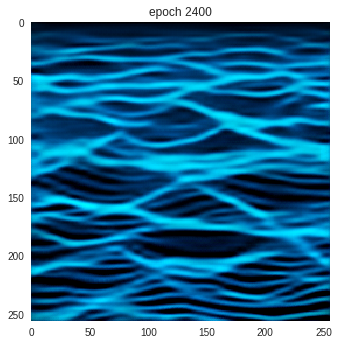

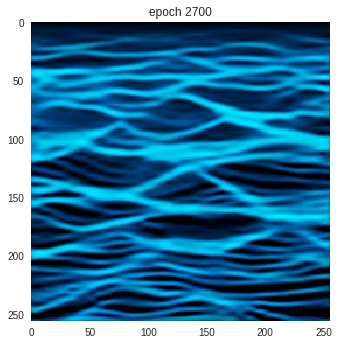

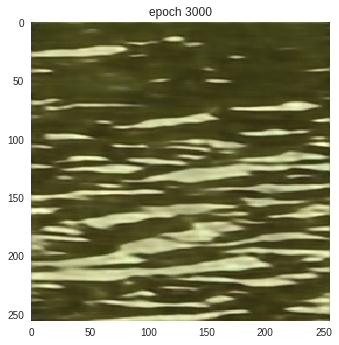

In [20]:
dt = 3
dyntex_data = DynTexDataset('./data/dynamic_textures/', textures, dt)
epochs = 3000
print_freq = epochs // 10
save_freq = epochs // 5
batch_size = 20

dataloader = DataLoader(dyntex_data, batch_size=batch_size,
                      shuffle=True, num_workers=5)


for epoch in tqdm_notebook(range(epoch,epochs + 1)):
  
    model.train()
  
    for seq_batch, y_batch in dataloader:
      
        seq_batch = seq_batch.cuda()
        y_batch = y_batch.cuda()

        optimizer.zero_grad()

        pred = model(seq_batch)

        loss = torch.norm(y_batch - pred) / batch_size
        loss.backward()
        losses += [loss.detach().cpu().numpy()]

        optimizer.step()
  
    # show
    if epoch%print_freq == 0:
      
        model.eval()
        plt.figure()
        plt.imshow(deprocess(pred))
        plt.title('epoch {}'.format(epoch))
        plt.grid(False)  
        plt.show()
        
        
    if epoch%save_freq == 0:
      
        save_model(textures, batch_size, dt, epoch)




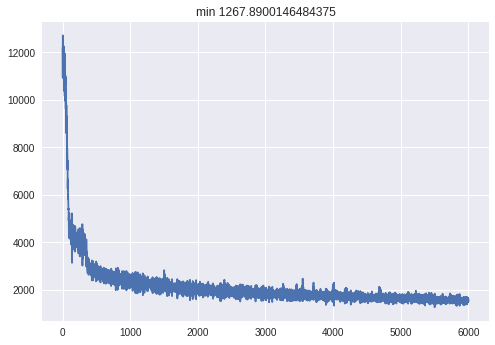

In [21]:
plt.plot(range(len(losses)), losses)
plt.title('min {}'.format(min(losses)))
plt.show()

## Generation

In [0]:
texture_type = 'water_5'
fold = './data/dynamic_textures/{}/'.format(texture_type)
model.eval()

target_seq_len = dt
generate_seq_len = 100
path_target = fold

names = sorted(os.listdir(fold))[:-6]

starting_seq, _ = get_seq(path_target, target_seq_len, 0)
current_seq = starting_seq.view(1,*starting_seq.shape).cuda()

generated_imgs = []

for i in tqdm_notebook(range(generate_seq_len)):

    new_img = model(current_seq)

    current_seq = torch.cat([current_seq[:,:,list(range(target_seq_len - 1)),:,:,],
                             new_img.view(1,3,1,256,256)], 2).cuda()
    
    generated_imgs += [deprocess(new_img.detach())]


clear_output()

## Saving

In [0]:
save = True
plot = False

fold_save = './{}_generated/'.format(texture_type)
names = sorted(os.listdir(fold))

if save:
    if not os.path.isdir(fold_save):
        os.mkdir(fold_save)
    else:
        shutil.rmtree(fold_save)
        os.mkdir(fold_save)

for i,img in enumerate(generated_imgs):
    
    if plot:
        if i + target_seq_len < len(names):
            fig, ax = plt.subplots(ncols=2, nrows=1)

            ax[0].imshow(img)
            ax[0].grid(False)
            ax[1].imshow(io.imread(os.path.join(fold, names[i + target_seq_len])))
            ax[1].grid(False)
        else:
            plt.figure()
            plt.imshow(img)

        plt.grid(False)

    if save:
        image_name = os.path.join(fold_save, '{}.jpg'.format(i))
        plt.imsave(image_name, img)
        files.download(image_name)         